In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from MinAggGNN import MinAggGNN
import matplotlib.pyplot as plt

device = torch.device('cuda')
L = 2
m = 2
eta = 0.0001
epochs = 20000

model = MinAggGNN(1, 8, L, 1, edge_dim = 1)
model.load_state_dict(torch.load('model_progress/model_final.pt'))
model.eval()
model.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


MinAggGNN(1, 1, num_layers=2)

In [ ]:
from ComputationGraph import ComputationGraph, create_circuit
import torch_geometric as pyg
import networkx as nx

G = ComputationGraph(model)
G.add_inputs({'edge_attr' : [1, model.convs[0].agg_mlp.lins[0].weight[:,-1]],
              'input_self' : [3, model.convs[0].up_mlp.lins[0].weight[:,-1]]})
G.add_residual_connections({'edge_attr' : [5, model.convs[1].agg_mlp.lins[0].weight[:,-1].reshape(1,-1).cpu().detach()]})
G.add_residual_connections({4 : [7, model.convs[1].up_mlp.lins[0].weight[:,-8:].T.cpu().detach()]})

In [ ]:
from EAPScores import compute_eap_scores
criterion = torch.nn.MSELoss()
test_data = torch.load('data/test_data.pt', map_location=device)
corrupted_data = torch.load('data/test_data.pt', map_location=device)
for data_corr in corrupted_data:
    data_corr.edge_attr = torch.zeros_like(data_corr.edge_attr, device=device)

In [ ]:
all_scores = []
avg_scores = {}
for data, data_corr in zip(test_data, corrupted_data):
    all_scores.append(compute_eap_scores(model, data, data_corr, criterion))
for key in all_scores[0].keys():
    avg_scores[key] = torch.mean(torch.stack([score_dict[key] for score_dict in all_scores]), 0)

c:\Users\heje197\AppData\Local\miniconda3\envs\stargazer\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


In [ ]:
for key, score in avg_scores.items():
    for j in range(score.shape[1]):
        v = key + f'.weight.{j}'
        for i, e in enumerate(G.in_edges(v)):
            nx.set_edge_attributes(G, {e : {'eap_score' : float(score[i,j].abs())}})

In [ ]:
G.calculate_scores(model, test_data, corrupted_data, criterion, which = 'EAP')

In [ ]:
K = 3
C = create_circuit(G, K, key='eap_score')

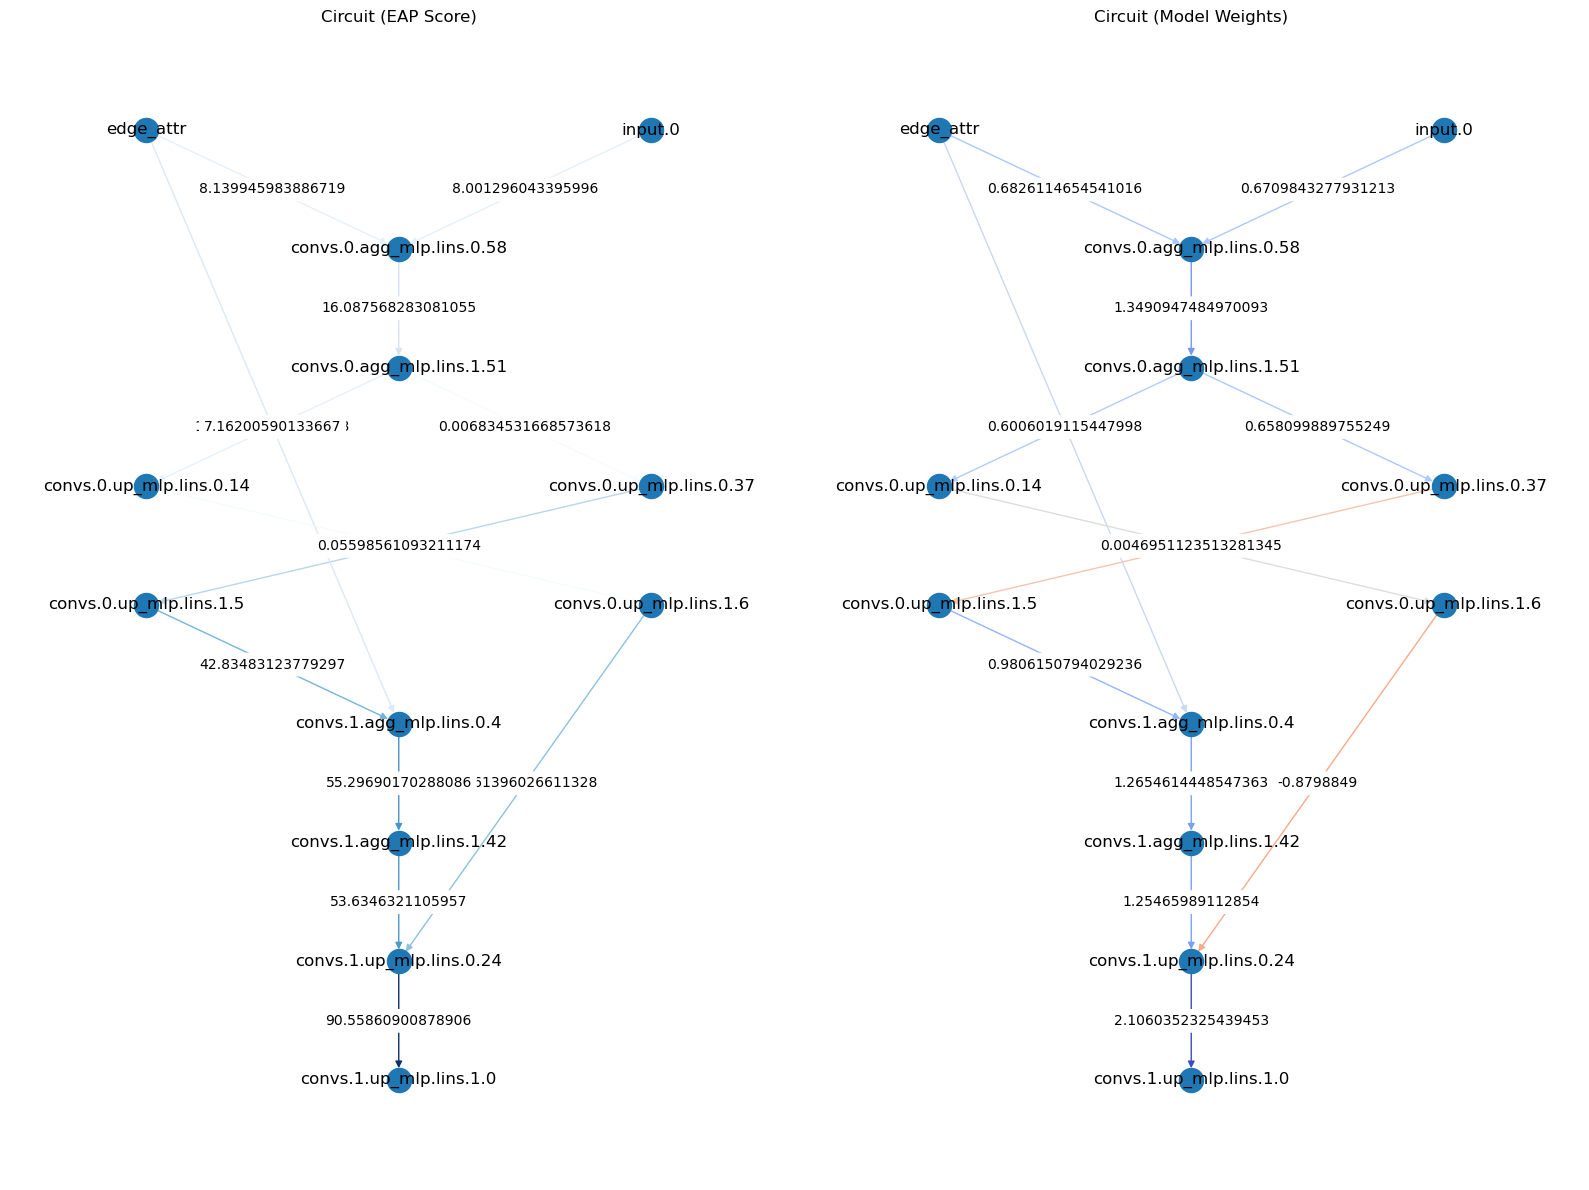

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 12))
c_pos = nx.multipartite_layout(C, subset_key='layer', align='horizontal')
c_pos = {node: (x,-y) for (node, (x,y)) in c_pos.items()}

circuit_edges, circuit_edge_scores = zip(*nx.get_edge_attributes(C,'eap_score').items())
nx.draw(C, pos = c_pos, ax=ax[0],
        edgelist=circuit_edges,
        edge_color=circuit_edge_scores,
        edge_cmap=plt.cm.Blues,
        with_labels=True
        )
nx.draw_networkx_edge_labels(C, pos = c_pos, ax=ax[0],
                             edge_labels=nx.get_edge_attributes(C,'eap_score'),
                             rotate=False)
ax[0].set_title('Circuit (EAP Score)')

_, circuit_edge_weights = zip(*nx.get_edge_attributes(C,'weight').items())
abs_vmax = max(circuit_edge_weights, key=abs)
nx.draw(C, pos = c_pos, ax=ax[1],
        edgelist = circuit_edges,
        edge_color = circuit_edge_weights,
        edge_cmap=plt.cm.coolwarm.reversed(),
        with_labels = True,
        edge_vmax = abs_vmax,
        edge_vmin = -abs_vmax
        )
nx.draw_networkx_edge_labels(C, pos = c_pos, ax=ax[1],
                             edge_labels=nx.get_edge_attributes(C,'weight'),
                             rotate=False)
ax[1].set_title('Circuit (Model Weights)')

ax[0].margins(x=.2)
ax[1].margins(x=.2)
plt.tight_layout()

In [ ]:
C_full = nx.graphviews.subgraph_view(G.to_directed(as_view=True), filter_node=G.has_node, filter_edge=C.has_edge)

In [ ]:
preds = set()
for v in G.top_sort[1]:
    preds = preds.union(set(G.predecessors(v)))

In [ ]:
preds

{'edge_attr', 'input.0'}

In [ ]:
nx.adjacency_matrix(C_full)

<396x396 sparse array of type '<class 'numpy.float64'>'
	with 13 stored elements in Compressed Sparse Row format>